In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt

In [2]:
# Load original dataset
SUSY = pd.read_csv("SUSY.csv", sep=',', header=None)

In [3]:
# Split data into training set and validation set
def stratifedSampling(target):
    suppersymIndices = np.array([i for i, val in enumerate(target) if val == 1])
    backgroundIndices = np.array([i for i, val in enumerate(target) if val == 0])
    np.random.shuffle(suppersymIndices); np.random.shuffle(backgroundIndices)

    trainIndices = np.concatenate(
        (suppersymIndices[:int(round(len(suppersymIndices) * 2 / 3))], backgroundIndices[:int(round(len(backgroundIndices) * 2 / 3))]), axis=None)
    validationIndices = np.concatenate(
        (suppersymIndices[int(round(len(suppersymIndices) * 2 / 3)):], backgroundIndices[int(round(len(backgroundIndices) * 2 / 3)):]), axis=None)
    np.random.shuffle(trainIndices); np.random.shuffle(validationIndices)
    
    return (trainIndices, validationIndices)

In [4]:
# Create Attributes set and Target Variable Set
X = SUSY.iloc[:, 1:]
Y = SUSY.iloc[:, 0].astype('int').astype('category')

# Normalization
X_tr = pd.concat([pd.DataFrame(np.ones(X.shape[0])), (X - X.mean()) / X.std()], axis=1, sort=False) 
print('Transformed mean:\n', X_tr.mean(), '. Transformed std:\n', X_tr.std(), sep='')

# Separate data into training set, test set, and valdiation set
X_test = X_tr.iloc[X_tr.shape[0] - 500000:, :].to_numpy()
Y_test = np.atleast_2d(Y.iloc[Y.shape[0] - 500000:].to_numpy()).T

trainIndices, validationIndices = (stratifedSampling(Y.iloc[:Y.shape[0] - 500000].to_numpy()))
X_train = X_tr.loc[trainIndices].to_numpy()
Y_train = np.atleast_2d(Y.loc[trainIndices].to_numpy()).T
X_val = X_tr.loc[validationIndices].to_numpy()
Y_val = np.atleast_2d(Y.loc[validationIndices].to_numpy()).T

Transformed mean:
0     1.000000e+00
1     1.131650e-16
2    -2.241056e-17
3     5.398051e-17
4    -9.424530e-17
5    -1.702857e-17
6    -3.001184e-17
7     1.622442e-15
8     4.227501e-17
9     2.837479e-14
10   -1.001936e-17
11    1.015888e-16
12   -6.176550e-16
13   -4.265611e-16
14    4.426324e-15
15   -1.377544e-16
16   -2.015959e-16
17    2.985900e-14
18    4.252254e-14
dtype: float64. Transformed std:
0     0.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
dtype: float64


In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Calculate a Regularized Cost and Gradients given a theta
def costFunctionReg(theta, attrs, target, lambda_value):
    m = target.shape[0]
    grad = np.zeros((theta.shape[0], 1))

    J = (1 / m) * np.sum(-target * np.log(sigmoid(np.matmul(attrs, theta))) - (1 - target) * np.log(1 - sigmoid(np.matmul(attrs, theta))))\
        + (lambda_value / (2 * m)) * np.sum(theta[1:theta.shape[0], :] * 2)

    grad[0, :] = (1 / m) * np.sum((sigmoid(np.matmul(attrs, theta)) - target) * np.atleast_2d(attrs[:, 0]).T)
    grad[1:theta.shape[0], :] = ((1 / m) * np.matmul(attrs[:, 1 : attrs.shape[1]].T, (sigmoid(np.matmul(attrs, theta)) - target)))\
        + ((lambda_value / m) * theta[1:theta.shape[0], :])

    return (J, grad)

# Predict a signal with a threshold of 0.5
def predict(theta, attrs):
    return (sigmoid(np.matmul(attrs, theta)) >= 0.5).astype(int)

# Calculate F Score of the model predictions
def calcFScore(predictions, target):
    TP = np.sum(np.logical_and(predictions, target))
    FP = np.sum(predictions > target)
    FN = np.sum(predictions < target)
    precision = TP/ (TP + FP)
    recall = TP / (TP + FN)
    return (2 * precision * recall) / (precision + recall)

<ipython-input-5-b884a35c315a>:9: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-target * np.log(sigmoid(np.matmul(attrs, theta))) - (1 - target) * np.log(1 - sigmoid(np.matmul(attrs, theta))))\
<ipython-input-5-b884a35c315a>:9: RuntimeWarning: invalid value encountered in multiply
  J = (1 / m) * np.sum(-target * np.log(sigmoid(np.matmul(attrs, theta))) - (1 - target) * np.log(1 - sigmoid(np.matmul(attrs, theta))))\


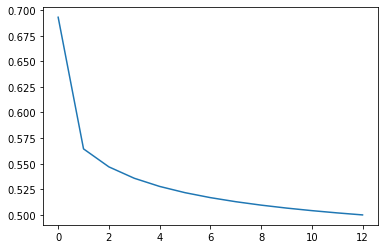

Best Regularization Parameter Lambda:  3
Best Gradient Descent Step Size:  1
Best Validation F Score:  0.7427706751559716


In [6]:
# Train and Fine-tune Model
lambda_values = list(range(1, 10, 2))
alphas = [1, 0.5, 0.05]

best_val_score = 0
best_lambda = 0
best_alpha = 0

for lambda_value, alpha in itertools.product(lambda_values, alphas):
    costs = []
    theta = np.zeros((X_train.shape[1], 1))
    
    # Train model
    for i in range(300):
        cost, grad = costFunctionReg(theta, X_train, Y_train, lambda_value)
        theta = theta - alpha * grad
        costs.append(cost)
    
    # Evaluate against Validation Data
    prediction_val = predict(theta, X_val)
    val_score = calcFScore(prediction_val, Y_val)

    if val_score > best_val_score:
        best_val_score = val_score
        best_lambda = lambda_value
        best_alpha = alpha
        best_theta = theta
        best_costs = costs.copy()

# Plot the cost graph as a function of number of iterations
plt.plot(best_costs)
plt.show()

# Report best hyperparameters and Score
print('Best Regularization Parameter Lambda: ', best_lambda)
print('Best Gradient Descent Step Size: ', best_alpha)
print('Best Validation F Score: ', best_val_score)

In [7]:
# Evaluation with Test Set and Report Final Result
predictions = predict(best_theta, X_test)
print('F-score of model performance on test set: ', calcFScore(predictions, Y_test))

F-score of model performance on test set:  0.7439133420890919
